# Chat with Multimodal Models: LLaVA

This notebook uses **LLaVA** as an example for the multimodal feature. More information about LLaVA can be found in their [GitHub page](https://github.com/haotian-liu/LLaVA)


### Before everything starts, install AutoGen with the `lmm` option
```bash
pip install "pyautogen[lmm]>=0.2.3"
```

In [53]:
# We use this variable to control where you want to host LLaVA, locally or remotely?
# More details in the two setup options below.
import json
import os
import random
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import requests
from PIL import Image
from termcolor import colored
import numpy as np

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.llava_agent import LLaVAAgent, llava_call
import glob
from natsort import natsorted

from yolov7_package import Yolov7Detector
import cv2
import inspect
import yolov7_package

LLAVA_MODE = "local"  # Either "local" or "remote"
assert LLAVA_MODE in ["local", "remote"]

<a id="local"></a>
## [Option 2] Setup LLaVA Locally


## Install the LLaVA library

Please follow the LLaVA GitHub [page](https://github.com/haotian-liu/LLaVA/) to install LLaVA.


#### Download the package
```bash
git clone https://github.com/haotian-liu/LLaVA.git
cd LLaVA
```

#### Install the inference package
```bash
conda create -n llava python=3.10 -y
conda activate llava
pip install --upgrade pip  # enable PEP 660 support
pip install -e .
```



Some helpful packages and dependencies:
```bash
conda install -c nvidia cuda-toolkit
```


### Launch

In one terminal, start the controller first:
```bash
python -m llava.serve.controller --host 0.0.0.0 --port 10000
```


Then, in another terminal, start the worker, which will load the model to the GPU:
```bash
python -m llava.serve.model_worker --host 0.0.0.0 --controller http://localhost:10000 --port 40000 --worker http://localhost:40000 --model-path liuhaotian/llava-v1.5-13b
``

In [5]:
# Run this code block only if you want to run LlaVA locally
if LLAVA_MODE == "local":
    llava_config_list = [
        {
            "model": "llava-v1.5-13b",
            "api_key": "None",
            "base_url": "http://0.0.0.0:10000",
        }
    ]

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LLaVA in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [82]:
images_dir = '/data/datasets/DashBoardData/Images'
images_list = natsorted(glob.glob(
    os.path.join(
        images_dir,
        'video-22-*'
    )
))

(1080, 1920, 3)


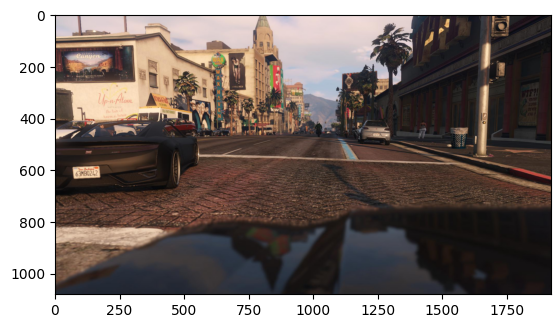

In [83]:
img_1 = Image.open(images_list[0])
print(np.array(img_1).shape)
plt.imshow(img_1)

In [91]:
image_agent = LLaVAAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": llava_config_list, "temperature": 0.5, "max_new_tokens": 100000},
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "groupchat",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
)

# Ask the question with an image


In [98]:
user_proxy.initiate_chat(
    image_agent,
    message=f"""describe the image.
<img {images_list[0]}>.""",
)

User_proxy (to image-explainer):

describe the image.
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: describe the image.
<image>.

###Assistant: 
image-explainer (to User_proxy):

Assistant: 

This image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.

--------------------------------------------------------------------------------


ChatResult(chat_history=[{'content': 'describe the image.\n<img /data/datasets/DashBoardData/Images/video-22-segment-1-frame-0.jpeg>.', 'role': 'assistant'}, {'content': 'Assistant: \n\nThis image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.', 'role': 'user'}], summary='', cost=({'total_cost': 0}, {'total_cost': 0}), human_input=[])

In [99]:
user_proxy.send(
    message=f"""Which objects are present in the image""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

Which objects are present in the image

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: describe the image.
<image>.
###Assistant: Assistant: 

This image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.
###Human: Which objects are present in the image

###Assistant: 
image-explainer (to User_proxy):

Assistant: 

In the image, there are several objects present, including multiple cars, a traffic light, buildings, palm trees, an

ChatResult(chat_history=[{'content': 'describe the image.\n<img /data/datasets/DashBoardData/Images/video-22-segment-1-frame-0.jpeg>.', 'role': 'assistant'}, {'content': 'Assistant: \n\nThis image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.', 'role': 'user'}, {'content': 'Which objects are present in the image', 'role': 'assistant'}, {'content': 'Assistant: \n\nIn the image, there are several objects present, including multiple cars, a traffic light, buildings, palm trees, and water on the road.', 'role': 'user'}], summary=None, cost=({'total_cost': 0}, {'total_cost': 0}),

In [100]:
user_proxy.send(
    message=f"""Can you extract bounding boxes for those objects?""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

Can you extract bounding boxes for those objects?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: describe the image.
<image>.
###Assistant: Assistant: 

This image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.
###Human: Which objects are present in the image
###Assistant: Assistant: 

In the image, there are several objects present, including multiple cars, a traffic light, buildings, palm trees, and water on the road.
###H

ChatResult(chat_history=[{'content': 'describe the image.\n<img /data/datasets/DashBoardData/Images/video-22-segment-1-frame-0.jpeg>.', 'role': 'assistant'}, {'content': 'Assistant: \n\nThis image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.', 'role': 'user'}, {'content': 'Which objects are present in the image', 'role': 'assistant'}, {'content': 'Assistant: \n\nIn the image, there are several objects present, including multiple cars, a traffic light, buildings, palm trees, and water on the road.', 'role': 'user'}, {'content': 'Can you extract bounding boxes for those objec

In [101]:
user_proxy.send(
    message=f"""How confident are you about the detected objects? You can consider mentioning confidence level of each detection.""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

How confident are you about the detected objects? You can consider mentioning confidence level of each detection.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: describe the image.
<image>.
###Assistant: Assistant: 

This image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.
###Human: Which objects are present in the image
###Assistant: Assistant: 

In the image, there are several objects present, including multiple cars, a t

ChatResult(chat_history=[{'content': 'describe the image.\n<img /data/datasets/DashBoardData/Images/video-22-segment-1-frame-0.jpeg>.', 'role': 'assistant'}, {'content': 'Assistant: \n\nThis image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.', 'role': 'user'}, {'content': 'Which objects are present in the image', 'role': 'assistant'}, {'content': 'Assistant: \n\nIn the image, there are several objects present, including multiple cars, a traffic light, buildings, palm trees, and water on the road.', 'role': 'user'}, {'content': 'Can you extract bounding boxes for those objec

In [ ]:
user_proxy.send(
    message=f"""Return numeric confident score""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

Return numeric confident score

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: describe the image.
<image>.
###Assistant: Assistant: 

This image is a video game screenshot featuring a city street with multiple cars. The scene shows a black sports car driving down the street, with a few other cars around it. The street is quite busy, and traffic appears to be flowing smoothly. The environment is further enhanced by the presence of palm trees, buildings, and a traffic light. The video game setting is depicted through the use of a reflection in the water on the road, adding depth and realism to the scene.
###Human: Which objects are present in the image
###Assistant: Assistant: 

In the image, there are several objects present, including multiple cars, a traffic light, buildings, palm trees, and water on the road.
###Human: Can you extra

## YOLOv7 
YOLOv7 is used to detect objects and their corresponding bounding boxes. YOLOv7 is installed using the following command
```bash
pip install yolov7-package
```

In [79]:
functions_list = inspect.getmembers(Yolov7Detector, inspect.isfunction)
print([func[0] for func in functions_list])

['__init__', 'detect', 'draw_on_image', 'train']


In [93]:
frm_bb_dict = {}

for f, img_path in enumerate(images_list[:4]):
    img = np.array(Image.open(img_path))
    det = Yolov7Detector(traced=False)
    # print(det.names)
    classes, boxes, scores = det.detect(img)
    img = det.draw_on_image(img, boxes[0], scores[0], classes[0])
    bb_dict = {}
    
    for i, cls in enumerate(classes[0]):
        # key = det.names[cls]+' 1'
        # while key in bb_dict.keys():
        #     key = key.split()[0] + f' {int(key.split()[1])+1}'
        if det.names[cls]+'s' not in bb_dict.keys():
            bb_dict[det.names[cls]+'s'] = []
        bb_dict[det.names[cls]+'s'].append(boxes[0][i])
    
    # img = Image.fromarray(img)
    # img.show()
    # print(bb_dict)
    frm_bb_dict[f'frame {f}'] = bb_dict

frm_bb_dict

Fusing layers... 
Fusing layers... 
Fusing layers... 
Fusing layers... 


{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375],
   [0.703125, 284.765625, 72.609375, 440.4375]],
  'cars': [[406.875, 400.359375, 544.875, 464.484375],
   [0.1875, 407.953125, 156.75, 445.5],
   [1151.25, 408.5859375, 1299.75, 507.09375],
   [0.9375, 408.375, 562.5, 683.4375]],
  'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]],
  'persons': [[1398.75, 413.4375, 1437.75, 481.78125],
   [1002.75, 418.7109375, 1034.25, 474.609375]]},
 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125],
   [1326.0, 422.296875, 1368.0, 505.828125],
   [882.0, 460.6875, 909.0, 506.25]],
  'cars': [[394.875, 488.53125, 482.625, 526.5],
   [0.09375, 451.40625, 124.03125, 493.59375],
   [1034.25, 421.6640625, 1223.25, 558.5625],
   [0.75, 459.421875, 414.375, 637.453125]]},
 'frame 2': {'cars': [[474.0, 507.09375, 561.75, 541.6875],
   [299.625, 492.75, 469.875, 553.5],
   [32.34375, 502.03125, 312.0, 581.34375],
   [524.25, 475.875, 864.75, 624.375]],
  'persons': [[1

In [94]:
# user_proxy.initiate_chat(
#     image_agent,
#     message=f"""What's the brand of this car?
# <img {images_list[0]}>.""",
# )
user_proxy.initiate_chat(
    image_agent,
    message=f"""Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.
{frm_bb_dict}""",
)

User_proxy (to image-explainer):

Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.
{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0, 505.828125], [882.0, 460.6875, 909.0, 506.25]], 'cars': [[394.875, 488.53125, 482.625, 526.5], [0.09375, 451.40625, 124.03125, 493.59375], [1034.25, 421.6640625, 1223.25, 558.5625], [0.75, 459.421875, 414.375, 637.453125

ChatResult(chat_history=[{'content': "Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.\n{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0, 505.828125], [882.0, 460.6875, 909.0, 506.25]], 'cars': [[394.875, 488.53125, 482.625, 526.5], [0.09375, 451.40625, 124.03125, 493.59375], [1034.25, 421.6640625, 1223.25, 558.5625], [0.75, 459.421875, 414.375, 637.4

In [95]:
# Ask the question with an image
# user_proxy.send(
#     message=f"""how many persons are there in the image?
#         <img {images_list[3]}>""",
#     recipient=image_agent,
# )

user_proxy.send(
    message=f"""describe the high-level event in the video""",
    recipient=image_agent,
)


User_proxy (to image-explainer):

describe the high level event in the video

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.
{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0, 505.828125

ChatResult(chat_history=[{'content': "Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.\n{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0, 505.828125], [882.0, 460.6875, 909.0, 506.25]], 'cars': [[394.875, 488.53125, 482.625, 526.5], [0.09375, 451.40625, 124.03125, 493.59375], [1034.25, 421.6640625, 1223.25, 558.5625], [0.75, 459.421875, 414.375, 637.4

In [96]:
user_proxy.send(
    message=f"""track any of the cars and detect in which direction the car is moving""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

track any of the cars and detect in which direction the car is moving?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.
{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 42

ChatResult(chat_history=[{'content': "Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.\n{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0, 505.828125], [882.0, 460.6875, 909.0, 506.25]], 'cars': [[394.875, 488.53125, 482.625, 526.5], [0.09375, 451.40625, 124.03125, 493.59375], [1034.25, 421.6640625, 1223.25, 558.5625], [0.75, 459.421875, 414.375, 637.4

In [97]:
user_proxy.send(
    message=f"""track using bounding box overlap in consecutive frames""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

track using bounding box overlap in consecutive frames

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
You are an AI agent and you can view images.
###Human: Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.
{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0

ChatResult(chat_history=[{'content': "Based on the detected objects and their corresponding bounding boxes in some keyframes of a video, describe the events in the video. Detected objects and bounding boxes are given in the following dictionary.\n{'frame 0': {'trucks': [[243.9375, 357.328125, 545.25, 471.234375], [0.703125, 284.765625, 72.609375, 440.4375]], 'cars': [[406.875, 400.359375, 544.875, 464.484375], [0.1875, 407.953125, 156.75, 445.5], [1151.25, 408.5859375, 1299.75, 507.09375], [0.9375, 408.375, 562.5, 683.4375]], 'traffic lights': [[1680.0, 0.4482421875, 1755.0, 89.54296875]], 'persons': [[1398.75, 413.4375, 1437.75, 481.78125], [1002.75, 418.7109375, 1034.25, 474.609375]]}, 'frame 1': {'persons': [[821.25, 472.5, 845.25, 497.8125], [1326.0, 422.296875, 1368.0, 505.828125], [882.0, 460.6875, 909.0, 506.25]], 'cars': [[394.875, 488.53125, 482.625, 526.5], [0.09375, 451.40625, 124.03125, 493.59375], [1034.25, 421.6640625, 1223.25, 558.5625], [0.75, 459.421875, 414.375, 637.4